<a href="https://colab.research.google.com/github/LeslyJaramillo/INTELIGENCIA-ARTIFICIAL/blob/main/correcto_punto_dos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install keras-vis

# IMPORTAR LIBRERIAS

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import fashion_mnist
from matplotlib.offsetbox import OffsetImage, AnnotationBbox


# CARAGAR EL DATASET

En esta parte de codigo se carga y procesa el conjunto de datos Fashion MNIST tanto los de entrenamiento y prueba para ser utilizado en un modelo de aprendizaje automático, como una red neuronal. Depues se normaliza los valores de los píxeles a un rango de [0, 1] dividiendo por 255. y se redimensionar las imágenes a un formato compatible con redes convolucionales, añadiendo una dimensión para el canal de color.

In [4]:
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 1us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


# AUTOENCODER REGULARIZADO

Un autoencoder regularizado es una variante del autoencoder tradicional que incorpora técnicas de regularización para evitar el sobreajuste y mejorar la generalización del modelo. Su estructura básica consiste en un codificador que mapea las imágenes de entrada a un espacio latente de menor dimensión y un decodificador que reconstruye las imágenes originales a partir de esta representación latente.

En esta sección se define un autoencoder que comprime imágenes (encoder) y luego las reconstruye (decoder). El encoder reduce la imagen a una representación más pequeña (espacio latente), y el decoder intenta reconstruir la imagen original desde esa representación comprimida. Utiliza capas densas con funciones de activación y regularización para mejorar el aprendizaje del modelo.

In [5]:
class Autoencoder(Model):
    def __init__(self, latent_dim):
        super(Autoencoder, self).__init__()
        self.latent_dim = latent_dim
        self.encoder = tf.keras.Sequential([
            layers.Flatten(),
            layers.Dense(latent_dim, activation='relu'),
            layers.ActivityRegularization(l1=1e-5)  # Regularización L1
        ])
        self.decoder = tf.keras.Sequential([
            layers.Dense(784, activation='sigmoid'),
            layers.Reshape((28, 28, 1))
        ])

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

# AUTOENCODER VARACIONAL

Un autoencoder variacional (VAE) es un tipo de autoencoder que combina técnicas de autoencoding con métodos probabilísticos para aprender representaciones latentes de los datos. A diferencia de un autoencoder tradicional, el VAE no solo aprende a reconstruir las entradas, sino que también modela la distribución probabilística de las representaciones latentes.

En esta sección se define un Autoencoder Variacional (VAE) usando TensorFlow y Keras, que es un modelo generativo que aprende a representar datos en un espacio latente. La clase Sampling genera muestras del espacio latente a partir de la media y la varianza logarítmica producidas por el encoder. La clase VAE incluye un encoder que codifica datos en parámetros latentes, un decoder que reconstruye los datos a partir de las muestras latentes, y una función de pérdida que combina la pérdida de reconstrucción con la pérdida KL para regularizar la distribución latente. El método train_step entrena el modelo ajustando los pesos para minimizar esta pérdida combinada.

In [6]:
class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

class VAE(Model):
    def __init__(self, latent_dim):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim
        self.encoder = tf.keras.Sequential([
            layers.Flatten(),
            layers.Dense(128, activation='relu'),
            layers.Dense(latent_dim + latent_dim)
        ])
        self.sampling = Sampling()
        self.decoder = tf.keras.Sequential([
            layers.Dense(128, activation='relu'),
            layers.Dense(784, activation='sigmoid'),
            layers.Reshape((28, 28, 1))
        ])

    def call(self, x):
        x = self.encoder(x)
        z_mean, z_log_var = tf.split(x, num_or_size_splits=2, axis=1)
        z = self.sampling((z_mean, z_log_var))
        reconstructed = self.decoder(z)
        return reconstructed, z_mean, z_log_var

    def vae_loss(self, x, reconstructed, z_mean, z_log_var):
        reconstruction_loss = tf.reduce_mean(
            tf.reduce_sum(
                losses.binary_crossentropy(x, reconstructed), axis=(1, 2)
            )
        )
        kl_loss = -0.5 * tf.reduce_mean(
            tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=1)
        )
        return reconstruction_loss + kl_loss

    def train_step(self, data):
        x = data
        with tf.GradientTape() as tape:
            reconstructed, z_mean, z_log_var = self(x)
            loss = self.vae_loss(x, reconstructed, z_mean, z_log_var)
        grads = tape.gradient(loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        return {"loss": loss}


# GANs

Una Red Neuronal Generativa (GAN) es un modelo de aprendizaje automático que consta de dos redes neuronales en competencia: el generador, que crea datos sintéticos imitando datos reales, y el discriminador, que intenta distinguir entre datos reales y falsos. Durante el entrenamiento, el generador mejora para engañar al discriminador, mientras que el discriminador se esfuerza por no ser engañado. Este proceso competitivo permite que el generador produzca datos cada vez más realistas.

En esta sección se define una Red Neuronal Generativa(GAN) usando TensorFlow y Keras, que consta de un generador y un discriminador. El generador crea imágenes a partir de ruido aleatorio, mientras que el discriminador evalúa si las imágenes son reales o falsas. La función de pérdida para el generador trata de maximizar la probabilidad de que el discriminador clasifique las imágenes generadas como reales, mientras que la pérdida del discriminador busca distinguir entre imágenes reales y generadas. El método train_step actualiza los pesos de ambos modelos usando gradientes calculados a partir de estas pérdidas para mejorar su rendimiento en un proceso adversarial iterativo.

In [7]:
# Definir la GAN
class GAN(Model):
    def __init__(self):
        super(GAN, self).__init__()
        self.generator = tf.keras.Sequential([
            layers.Dense(256, activation='relu', input_shape=(100,)),
            layers.BatchNormalization(),
            layers.LeakyReLU(),
            layers.Dense(28 * 28, activation='sigmoid'),
            layers.Reshape((28, 28, 1))
        ])
        self.discriminator = tf.keras.Sequential([
            layers.Flatten(input_shape=(28, 28, 1)),
            layers.Dense(256),
            layers.LeakyReLU(),
            layers.Dense(1, activation='sigmoid')
        ])
        self.cross_entropy = losses.BinaryCrossentropy(from_logits=True)

    def compile(self, generator_optimizer, discriminator_optimizer):
        super(GAN, self).compile()
        self.generator_optimizer = generator_optimizer
        self.discriminator_optimizer = discriminator_optimizer

    def train_step(self, images):
        noise = tf.random.normal([batch_size, 100])

        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
            generated_images = self.generator(noise, training=True)

            real_output = self.discriminator(images, training=True)
            fake_output = self.discriminator(generated_images, training=True)

            gen_loss = self.generator_loss(fake_output)
            disc_loss = self.discriminator_loss(real_output, fake_output)

        gradients_of_generator = gen_tape.gradient(gen_loss, self.generator.trainable_variables)
        gradients_of_discriminator = disc_tape.gradient(disc_loss, self.discriminator.trainable_variables)

        self.generator_optimizer.apply_gradients(zip(gradients_of_generator, self.generator.trainable_variables))
        self.discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, self.discriminator.trainable_variables))

        return {"gen_loss": gen_loss, "disc_loss": disc_loss}

    def generator_loss(self, fake_output):
        return self.cross_entropy(tf.ones_like(fake_output), fake_output)

    def discriminator_loss(self, real_output, fake_output):
        real_loss = self.cross_entropy(tf.ones_like(real_output), real_output)
        fake_loss = self.cross_entropy(tf.zeros_like(fake_output), fake_output)
        return real_loss + fake_loss

# EVALUAR LOS MODELOS

En esta sección se entrena y evalúa tres modelos generativos,un autoencoder regularizado, un autoencoder variacional (VAE) y una red generativa antagónica (GAN) y luego usa un clasificador de imágenes para evaluar la calidad de las imágenes generadas por estos modelos. Primero, se construye y entrena un autoencoder, un VAE y una GAN, generando imágenes reconstruidas o nuevas imágenes en el proceso. Luego, se clasifica la calidad de estas imágenes usando un clasificador de red neuronal para evaluar la precisión de las imágenes reconstruidas o generadas en comparación con las etiquetas verdaderas. Finalmente, se imprime la precisión del clasificador para cada tipo de imagen generada, permitiendo la comparación de la calidad entre las imágenes generadas por los diferentes modelos.

In [8]:

# Definir el clasificador de imágenes
def build_classifier():
    model = tf.keras.Sequential([
        layers.Flatten(input_shape=(28, 28, 1)),
        layers.Dense(128, activation='relu'),
        layers.Dense(10, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Entrenar y evaluar los modelos
latent_dim = 64
batch_size = 128

# Entrenar Autoencoder Regularizado
autoencoder = Autoencoder(latent_dim)
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())
autoencoder.fit(x_train, x_train, epochs=10, batch_size=batch_size, validation_data=(x_test, x_test))

# Entrenar VAE
vae = VAE(latent_dim)
vae.compile(optimizer='adam')
vae.fit(x_train, epochs=10, batch_size=batch_size)

# Entrenar GAN
gan = GAN()
gan.compile(generator_optimizer=tf.keras.optimizers.Adam(1e-4),
            discriminator_optimizer=tf.keras.optimizers.Adam(1e-4))
gan.fit(x_train, epochs=10, batch_size=batch_size)

# Clasificación de imágenes
classifier = build_classifier()

# Clasificación con imágenes reconstruidas por el autoencoder regularizado
decoded_imgs = autoencoder.predict(x_test)
classifier.fit(decoded_imgs, y_test, epochs=10, batch_size=batch_size, validation_data=(x_test, y_test))
autoencoder_acc = classifier.evaluate(decoded_imgs, y_test)[1]

# Clasificación con imágenes generadas por VAE
vae_imgs, _, _ = vae.predict(x_test)
classifier.fit(vae_imgs, y_test, epochs=10, batch_size=batch_size, validation_data=(x_test, y_test))
vae_acc = classifier.evaluate(vae_imgs, y_test)[1]

# Clasificación con imágenes generadas por GAN
noise = tf.random.normal([x_test.shape[0], 100])
gan_imgs = gan.generator.predict(noise)
classifier.fit(gan_imgs, y_test, epochs=10, batch_size=batch_size, validation_data=(x_test, y_test))
gan_acc = classifier.evaluate(gan_imgs, y_test)[1]

print(f"Accuracy with Autoencoder Regularized: {autoencoder_acc}")
print(f"Accuracy with VAE: {vae_acc}")
print(f"Accuracy with GAN: {gan_acc}")



Epoch 1/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - loss: 0.1196 - val_loss: 0.0608
Epoch 2/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - loss: 0.0570 - val_loss: 0.0492
Epoch 3/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - loss: 0.0478 - val_loss: 0.0437
Epoch 4/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 0.0429 - val_loss: 0.0409
Epoch 5/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - loss: 0.0402 - val_loss: 0.0379
Epoch 6/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0376 - val_loss: 0.0366
Epoch 7/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.0363 - val_loss: 0.0357
Epoch 8/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.0356 - val_loss: 0.0349
Epoch 9/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.0348 - val_loss: 0.0343
Epoch 10/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0342 - val_loss: 0.0338
Epoch 1/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - loss: 309.7324
Epoch 2/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 270

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/nn.py:681: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


469/469 ━━━━━━━━━━━━━━━━━━━━ 11s 19ms/step - disc_loss: 0.4122 - gen_loss: 2.3824
Epoch 2/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - disc_loss: 0.3396 - gen_loss: 2.1290
Epoch 3/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - disc_loss: 0.4292 - gen_loss: 1.9033
Epoch 4/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - disc_loss: 0.4892 - gen_loss: 1.7909
Epoch 5/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - disc_loss: 0.4347 - gen_loss: 1.9426
Epoch 6/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - disc_loss: 0.3445 - gen_loss: 2.1753
Epoch 7/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 11s 19ms/step - disc_loss: 0.3120 - gen_loss: 2.2077
Epoch 8/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step - disc_loss: 0.4332 - gen_loss: 1.8450
Epoch 9/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - disc_loss: 0.6358 - gen_loss: 1.4481
Epoch 10/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - disc_loss: 0.5567 - gen_loss: 1.5923
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Epoch 1/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/

# RESULTADO

En esta sección se visualiza y compara las imágenes generadas por cuatro modelos diferentes en una sola figura. Muestra un conjunto de imágenes originales del conjunto de datos de prueba, seguido de imágenes generadas por una Red Generativa Antagónica (GAN), un Autoencoder Variacional (VAE), y un autoencoder regularizado

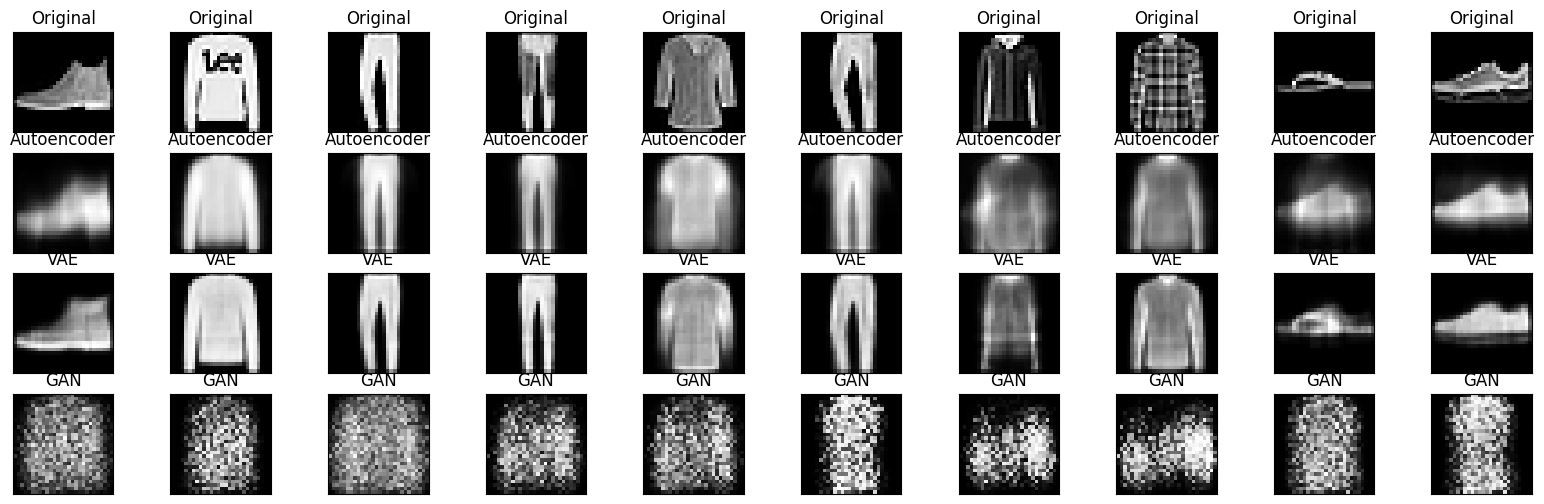

In [9]:
# Mostrar imágenes generadas y resultados
n = 10
plt.figure(figsize=(20, 6))
for i in range(n):
    # Mostrar imágenes originales
    ax = plt.subplot(4, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28), cmap='gray')
    plt.title("Original")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

     # Mostrar imágenes generadas por la GAN
    ax = plt.subplot(4, n, i + 1 + 3 * n)
    plt.imshow(gan_imgs[i].reshape(28, 28), cmap='gray')
    plt.title("GAN")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Mostrar imágenes generadas por el VAE
    ax = plt.subplot(4, n, i + 1 + 2 * n)
    plt.imshow(vae_imgs[i].reshape(28, 28), cmap='gray')
    plt.title("VAE")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)


    # Mostrar imágenes reconstruidas por el Autoencoder
    ax = plt.subplot(4, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28), cmap='gray')
    plt.title("Autoencoder")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)




plt.show()

En las imágenes resultantes de los modelos, se puede observar que tanto el autoencoder como el Autoencoder Variacional (VAE) logran reconstrucciones muy cercanas a las imágenes originales. Esto indica que estos modelos son efectivos para capturar las características clave de los datos y regenerar imágenes con alta fidelidad. En contraste, las imágenes generadas por la Red Generativa Antagónica (GAN) presentan una calidad deficiente, mostrando principalmente ruido en lugar de estructuras discernibles.

# ESPACIO LATENTE

En esta sección del código realiza dos tareas principales, primero, convierte el fondo de las imágenes generadas por un VAE (Autoencoder Variacional) en transparente usando una función que crea una imagen RGBA donde el canal alfa determina la transparencia basada en un umbral de intensidad; segundo, muestra estas imágenes transparentes en un gráfico de dispersión donde las posiciones de las imágenes están determinadas por sus coordenadas en el espacio latente del VAE. Esto se logra mediante la creación de un scatter plot en el que las imágenes se colocan sobre las posiciones correspondientes en el espacio latente, proporcionando una visualización clara de cómo las imágenes generadas se distribuyen en dicho espacio.

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


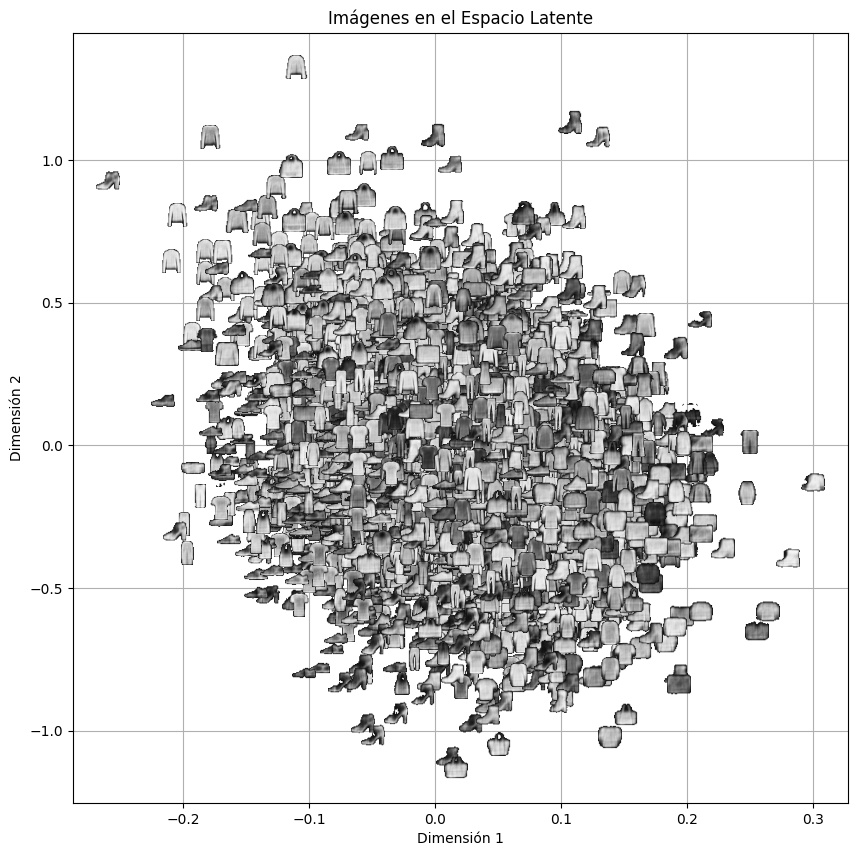

In [10]:

# Función para hacer el fondo transparente
def remove_background(image):
    rgba_image = np.zeros((image.shape[0], image.shape[1], 4))
    rgba_image[..., 0] = image[..., 0]  # Rojo
    rgba_image[..., 1] = image[..., 0]  # Verde
    rgba_image[..., 2] = image[..., 0]  # Azul
    rgba_image[..., 3] = (image[..., 0] > 0.05).astype(float)  # Alpha (transparente)
    return rgba_image

# Obtener imágenes generadas y sus posiciones en el espacio latente
vae_imgs, z_mean, _ = vae.predict(x_test)

# Aplicar la función a todas las imágenes para hacer el fondo transparente
vae_imgs_transparent = np.array([remove_background(img) for img in vae_imgs])

# Función para mostrar las imágenes en el scatter plot sin fondo
def plot_latent_images(z_mean, images):
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.scatter(z_mean[:, 0], z_mean[:, 1], alpha=0)  # Puntos invisibles para las imágenes

    for i in range(len(images)):
        imagebox = OffsetImage(images[i], zoom=0.6, resample=True)
        ab = AnnotationBbox(imagebox, (z_mean[i, 0], z_mean[i, 1]), frameon=False)
        ax.add_artist(ab)

    ax.set_xlabel('Dimensión 1')
    ax.set_ylabel('Dimensión 2')
    ax.set_title('Imágenes en el Espacio Latente')
    plt.grid(True)
    plt.show()

# Mostrar las imágenes en el espacio latente con fondo transparente
plot_latent_images(z_mean, vae_imgs_transparent)
